# Antibody Response Pulse
https://github.com/blab/antibody-response-pulse

### B-cells evolution --- cross-reactive antibody response after influenza virus infection or vaccination
### Adaptive immune response for repeated infection

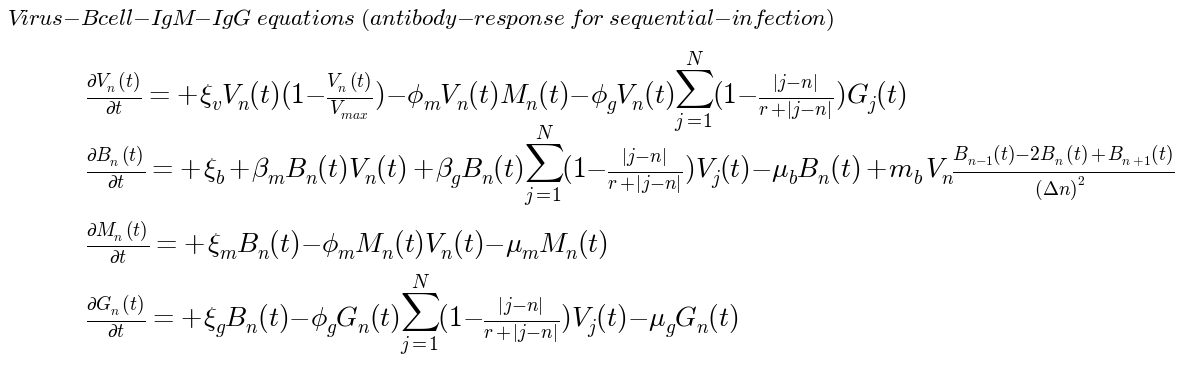

In [1]:
'''
author: Alvason Zhenhua Li
date:   04/09/2015
'''
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FuncFormatter

import alva_machinery_event_bcell as alva

AlvaFontSize = 23
AlvaFigSize = (15, 5)
numberingFig = 0

# plotting
dir_path = '/Users/al/Desktop/GitHub/antibody-response-pulse/bcell-array/figure'
file_name = 'Virus-Bcell-IgM-IgG'
figure_name = '-equation'
file_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize=(12, 6))
plt.axis('off')
plt.title(r'$ Virus-Bcell-IgM-IgG \ equations \ (antibody-response \ for \ sequential-infection) $'
          , fontsize = AlvaFontSize)
plt.text(0, 7.0/9, r'$ \frac{\partial V_n(t)}{\partial t} = \
         + \xi_{v}V_{n}(t)(1 - \frac{V_n(t)}{V_{max}}) \
         - \phi_{m} V_{n}(t) M_{n}(t) \
         - \phi_{g} V_{n}(t) \sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})G_{j}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 5.0/9, r'$ \frac{\partial B_n(t)}{\partial t} = \
         + \xi_{b} \
         + \beta_{m} B_{n}(t) V_{n}(t)  \
         + \beta_{g} B_{n}(t)\sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})V_{j}(t)  \
         - \mu_{b} B_{n}(t) \
         + m_b V_{n}\frac{B_{n-1}(t) - 2B_n(t) + B_{n+1}(t)}{(\Delta n)^2} $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 3.0/9,r'$ \frac{\partial M_n(t)}{\partial t} = \
         + \xi_{m} B_{n}(t) \
         - \phi_{m} M_{n}(t) V_{n}(t) \
         - \mu_{m} M_{n}(t) $'
         , fontsize = 1.2*AlvaFontSize)
plt.text(0, 1.0/9,r'$ \frac{\partial G_n(t)}{\partial t} = \
         + \xi_{g} B_{n}(t) \
         - \phi_{g} G_{n}(t) \sum_{j = 1}^{N} (1 - \frac{|j - n|}{r + |j - n|})V_{j}(t)  \
         - \mu_{g} G_{n}(t) $'         
         , fontsize = 1.2*AlvaFontSize)

plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()

# define the V-B-M-G partial differential equations

# inverted-monod equation
def monodInvert(half_radius, i):
    if half_radius == 0:
        gOut = i*0
        # numpy.reshape will not change the structure of i, 
        # so that the first element of i(unkonwn-size-array) can be setted by array_to_list[0] 
        array_to_list = np.reshape(i,[i.size,1]) 
        array_to_list[0] = 1 
    else: gOut = 1 - np.absolute(i)/(half_radius + np.absolute(i))
    return (gOut)

# cross immunity
def crossI_neighborSum_X(gI, half_radius, gX):
    total_neighbor_X = gX.shape[0]
    I_neighborSum = np.zeros(total_neighbor_X)
    # all I[xn] with neighbor-sum 
    ratioM = np.zeros([total_neighbor_X, total_neighbor_X])
    gXX = np.tile(gX, [total_neighbor_X, 1])
    gII = np.tile(gI, [total_neighbor_X, 1])
    ratioM[:, :] = monodInvert(half_radius, gXX[:, :] - gXX[:, :].T)
    I_neighborSum[:] = np.sum(ratioM[:, :] * gII[:, :].T, axis = 0)
    if half_radius == 0:
        I_neighborSum = np.copy(gI)
    return (I_neighborSum)

def dVdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dV_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dV_dt_array[:] = +inRateV*V[:]*(1 - V[:]/maxV) \
                     - killRateVm*M[:]*V[:] \
                     - killRateVg*V[:]*crossI_neighborSum_X(G, cross_radius, gX)[:]
    return(dV_dt_array)

def dBdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dB_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Bcopy = np.copy(B)
    centerX = Bcopy[:]
    leftX = np.roll(Bcopy[:], 1)
    rightX = np.roll(Bcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dB_dt_array[:] = +inRateB \
                     + actRateBm*V[:]*B[:] \
                     + (actRateBg \
                        + alva.event_recovered + alva.event_OAS_press \
                        + alva.event_recoveredV + alva.event_OAS_pressV) \
                        *B[:]*crossI_neighborSum_X(V, cross_radius, gX)[:] \
                     - (outRateB + alva.event_OAS_slowV)*B[:] \
                     + mutatRateB*V[:]*(leftX[:] - 2*centerX[:] + rightX[:])/(dx**2)
    return(dB_dt_array)

def dMdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dM_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    dM_dt_array[:] = +inRateM*B[:] - consumeRateM*M[:]*V[:] - outRateM*M[:]
    return(dM_dt_array)

def dGdt_array(VBMGxt = [], *args):
    # naming
    V = VBMGxt[0]
    B = VBMGxt[1]
    M = VBMGxt[2]
    G = VBMGxt[3]
    x_totalPoint = VBMGxt.shape[1]
    # there are n dSdt
    dG_dt_array = np.zeros(x_totalPoint)
    # each dSdt with the same equation form
    Gcopy = np.copy(G)
    centerX = Gcopy[:]
    leftX = np.roll(Gcopy[:], 1)
    rightX = np.roll(Gcopy[:], -1)
    leftX[0] = centerX[0]
    rightX[-1] = centerX[-1]
    dG_dt_array[:] = +(inRateG + alva.event_OAS_boost + alva.event_OAS_boostV)*B[:] \
                     - consumeRateG*G[:]*crossI_neighborSum_X(V, cross_radius, gX)[:] \
                     - outRateG*G[:]
    return(dG_dt_array)

event_infect = [[  0.   0.]
 [  4.   1.]
 [  4.  29.]
 [  0.  57.]]
event_repeated = [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
event_vaccine = [[  0.   0.]
 [  0.   1.]
 [  0.  29.]
 [  0.  57.]]


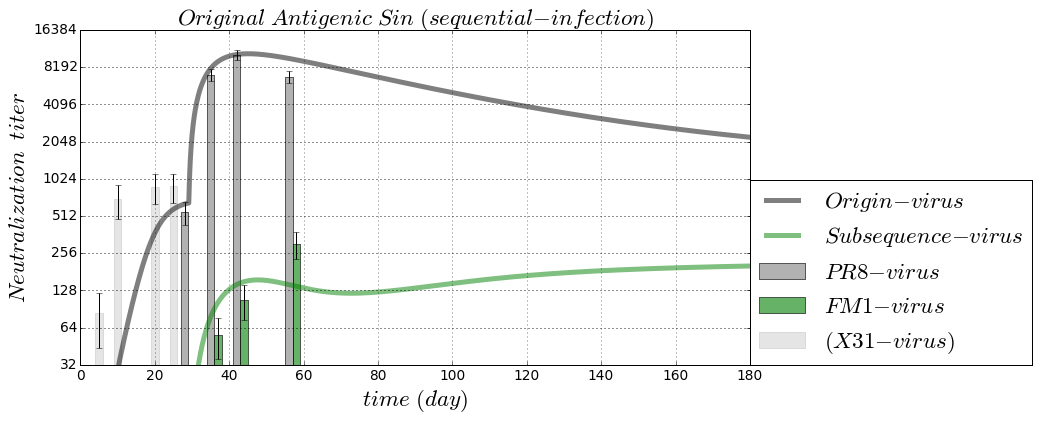

In [2]:
# setting parameter
timeUnit = 'day'
if timeUnit == 'hour':
    hour = float(1)
    day = float(24)
elif timeUnit == 'day':
    day = float(1)
    hour = float(1)/24 
elif timeUnit == 'year':
    year = float(1)
    day = float(1)/365
    hour = float(1)/24/365 
    
maxV = float(50) # max virus/micro-liter
inRateV = 0.2/hour # in-rate of virus
killRateVm = 0.0003/hour # kill-rate of virus by antibody-IgM
killRateVg = killRateVm # kill-rate of virus by antibody-IgG

inRateB = 0.01/hour # in-rate of B-cell
outRateB = inRateB/1.5 # out-rate of B-cell
actRateBm = killRateVm # activation rate of naive B-cell
actRateBg = killRateVg # activation rate of naive B-cell

inRateM = 0.16/hour # in-rate of antibody-IgM from naive B-cell
outRateM = inRateM/1  # out-rate of antibody-IgM from naive B-cell
consumeRateM = killRateVm # consume-rate of antibody-IgM by cleaning virus

inRateG = inRateM/10 # in-rate of antibody-IgG from memory B-cell
outRateG = outRateM/250 # out-rate of antibody-IgG from memory B-cell
consumeRateG = killRateVg  # consume-rate of antibody-IgG by cleaning virus
    
mutatRateB = 0.0001/hour # Virus mutation rate
cross_radius = float(0.015) # radius of cross-immunity (the distance of half-of-value in the Monod equation)

# time boundary and griding condition
minT = float(0)
maxT = float(7*28*day)
totalPoint_T = int(2*10**3 + 1)
gT = np.linspace(minT, maxT, totalPoint_T)
spacingT = np.linspace(minT, maxT, num = totalPoint_T, retstep = True)
gT = spacingT[0]
dt = spacingT[1]

# space boundary and griding condition
minX = float(0)
maxX = float(3)

totalPoint_X = int(maxX - minX + 1)
gX = np.linspace(minX, maxX, totalPoint_X)
gridingX = np.linspace(minX, maxX, num = totalPoint_X, retstep = True)
gX = gridingX[0]
dx = gridingX[1]
gV_array = np.zeros([totalPoint_X, totalPoint_T])
gB_array = np.zeros([totalPoint_X, totalPoint_T])
gM_array = np.zeros([totalPoint_X, totalPoint_T])
gG_array = np.zeros([totalPoint_X, totalPoint_T])
# initial output condition
#gV_array[1, 0] = float(2)

# [viral population, starting time] ---first
origin_virus = int(1)
current_virus = int(2)
infection_period = 1*28*day
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 4
infection_starting_time = np.arange(int(maxX + 1))*infection_period - 27
event_infect = np.zeros([int(maxX + 1), 2])
event_infect[:, 0] = viral_population
event_infect[:, 1] = infection_starting_time
event_infect[0, 1] = 0
print ('event_infect = {:}'.format(event_infect)) 

# [viral population, starting time] ---repeated
viral_population = np.zeros(int(maxX + 1))
viral_population[origin_virus:current_virus + 1] = 0
infection_starting_time = np.arange(int(maxX + 1))*0
event_repeated = np.zeros([int(maxX + 1), 2])
event_repeated[:, 0] = viral_population
event_repeated[:, 1] = infection_starting_time
print ('event_repeated = {:}'.format(event_repeated)) 

# [vaccine population, starting time] ---first
origin_vaccine = int(1)
current_vaccine = int(2)
vaccine_period = 1*28*day
vaccine_population = np.zeros(int(maxX + 1))
vaccine_population[origin_vaccine:current_vaccine + 1] = 0
vaccine_starting_time = np.arange(int(maxX + 1))*vaccine_period - 27
event_vaccine = np.zeros([int(maxX + 1), 2])
event_vaccine[:, 0] = vaccine_population
event_vaccine[:, 1] = vaccine_starting_time
event_vaccine[0, 1] = 0
print ('event_vaccine = {:}'.format(event_vaccine)) 

#[origin-virus, current-virus, recovered-day, repeated-parameter, OAS+, OSA-]
min_cell = 1 # minimum cell
recovered_time = 14*day # recovered time of 1st-time infection 
actRateBg_recovered = actRateBg*10 # activation rate of memory B-cell for repeated-infection (same virus)
inRateG_OAS_boost = 0.7/hour # boosting in-rate of antibody-IgG from memory B-cell for origin-virus
actRateBg_OAS_press = -0.0001/hour # depress act-rate from memory B-cell for non-origin-virus
outRateB_OAS_slow = 0.0 # not applied in infection
event_infection_parameter = np.array([origin_virus,
                                      current_virus, 
                                      min_cell, 
                                      recovered_time,
                                      actRateBg_recovered,
                                      inRateG_OAS_boost,
                                      actRateBg_OAS_press, 
                                      outRateB_OAS_slow])
# vaccination_parameter
# vaccination_parameter
# vaccination_parameter
min_cell_v = 0.2 # minimum cell
recovered_time_v = 14*day # recovered time of 1st-time infection 
actRateBg_recovered_v = actRateBg*9 # activation rate of memory B-cell for repeated-infection (same virus)
inRateG_OAS_boost_v = 2.0/hour # boosting in-rate of antibody-IgG from memory B-cell for origin-virus
actRateBg_OAS_press_v = -0.000/hour # depress act-rate from memory B-cell for non-origin-virus
outRateB_OAS_slow_v = -outRateB/1.6 
event_vaccination_parameter = np.array([origin_vaccine,
                                        current_vaccine, 
                                        min_cell_v, 
                                        recovered_time_v,
                                        actRateBg_recovered_v,
                                        inRateG_OAS_boost_v,
                                        actRateBg_OAS_press_v,
                                        outRateB_OAS_slow_v])

event_parameter = np.array([event_infection_parameter, event_vaccination_parameter])

event_table = np.array([event_parameter, event_infect, event_repeated, event_vaccine])

# Runge Kutta numerical solution
pde_array = np.array([dVdt_array, dBdt_array, dMdt_array, dGdt_array])
initial_Out = np.array([gV_array, gB_array, gM_array, gG_array])
gOut_array = alva.AlvaRungeKutta4XT(pde_array, initial_Out, minX, maxX, totalPoint_X, minT, maxT, totalPoint_T, event_table)

# plotting
gV = gOut_array[0]  
gB = gOut_array[1] 
gM = gOut_array[2]
gG = gOut_array[3]

# Experimental lab data from (Quantifying the Early Immune Response and Adaptive Immune) paper
gT_lab_fresh = np.array([0, 5, 10, 20, 25])
gIgG_lab_fresh = np.array([0, 0.5, 4, 8.5, 8.75])*10**2 
error_IgG_fresh = gIgG_lab_fresh**(4.0/5)
gIgM_lab_fresh = np.array([0, 1.0/3, 3, 1.0/3, 1.0/6])*10**2
error_IgM_fresh = gIgM_lab_fresh**(4.0/5)
gX31_lab_fresh = gIgG_lab_fresh + gIgM_lab_fresh
error_lab_fresh = error_IgG_fresh + error_IgM_fresh
bar_width = 1

# Experimental lab data from OAS paper
gT_lab = np.array([0, 7, 14, 28])*day + infection_period*origin_virus 
gPR8_lab = np.array([2**(9 + 1.0/10), 2**(13 - 1.0/5), 2**(13 + 1.0/3), 2**(13 - 1.0/4)])
standard_PR8 = gPR8_lab**(3.0/4)

gFM1_lab = np.array([0, 2**(6 - 1.0/5), 2**(7 - 1.0/4), 2**(8 + 1.0/4)])
standard_FM1 = gFM1_lab**(3.0/4)
bar_width = 2.0

# Sequential infection graph

numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (12, 6))
plt.subplot(111)
plt.plot(gT, (gM[origin_virus] + gG[origin_virus]), linewidth = 5.0, alpha = 0.5, color = 'black'
         , label = r'$ Origin-virus $')
plt.plot(gT, (gM[origin_virus + 1] + gG[origin_virus + 1]), linewidth = 5.0, alpha = 0.5, color = 'green'
         , label = r'$ Subsequence-virus $')
plt.bar(gT_lab - bar_width/2, gPR8_lab, bar_width, alpha = 0.6, color = 'gray', yerr = standard_PR8
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ PR8-virus $')
plt.bar(gT_lab + bar_width/2, gFM1_lab, bar_width, alpha = 0.6, color = 'green', yerr = standard_FM1
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ FM1-virus $')
plt.bar(gT_lab_fresh - bar_width/2, gX31_lab_fresh, bar_width, alpha = 0.1, color = 'black', yerr = error_lab_fresh
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ (X31-virus) $')
plt.grid(True, which = 'both')
plt.title(r'$ Original \ Antigenic \ Sin \ (sequential-infection)$', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.6)
plt.yticks(fontsize = AlvaFontSize*0.6) 
plt.xlim([minT, 6*30*day])
plt.ylim([2**5, 2**14])
plt.yscale('log', basey = 2)
# gca()---GetCurrentAxis and Format the ticklabel to be 2**x
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(2**(np.log(x)/np.log(2)))))
#plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.legend(loc = (1, 0), fontsize = AlvaFontSize)
plt.show()

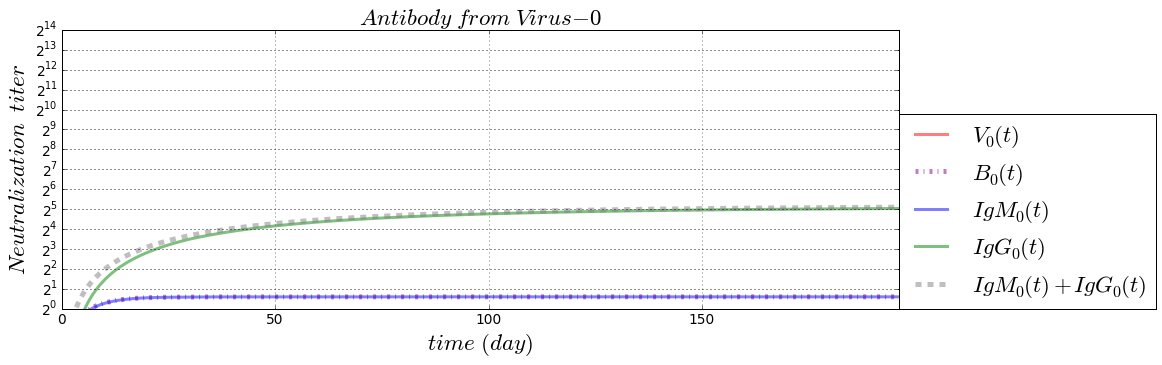

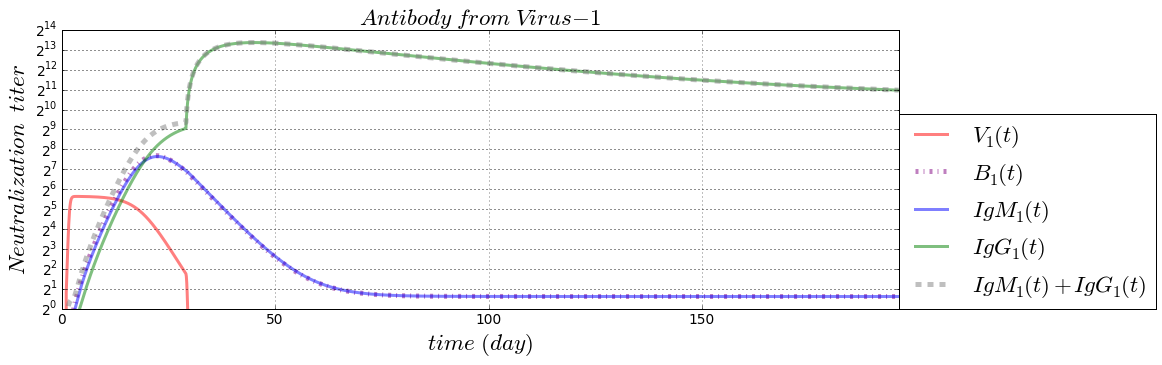

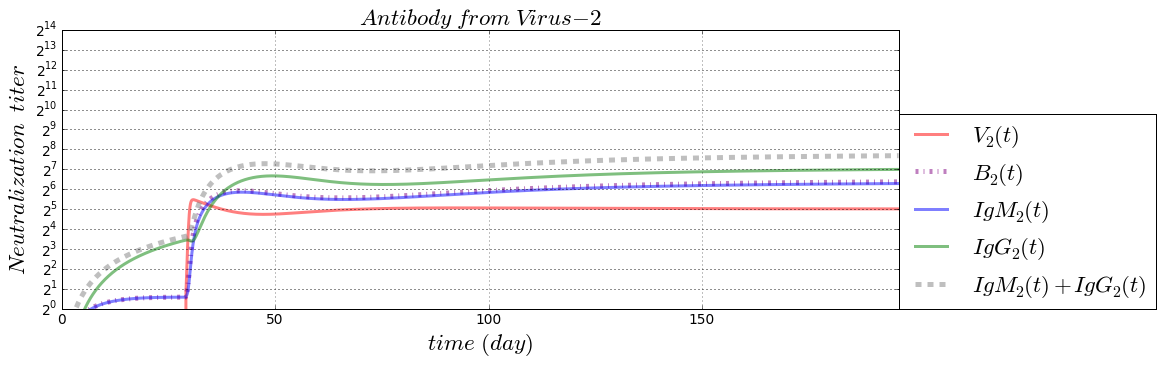

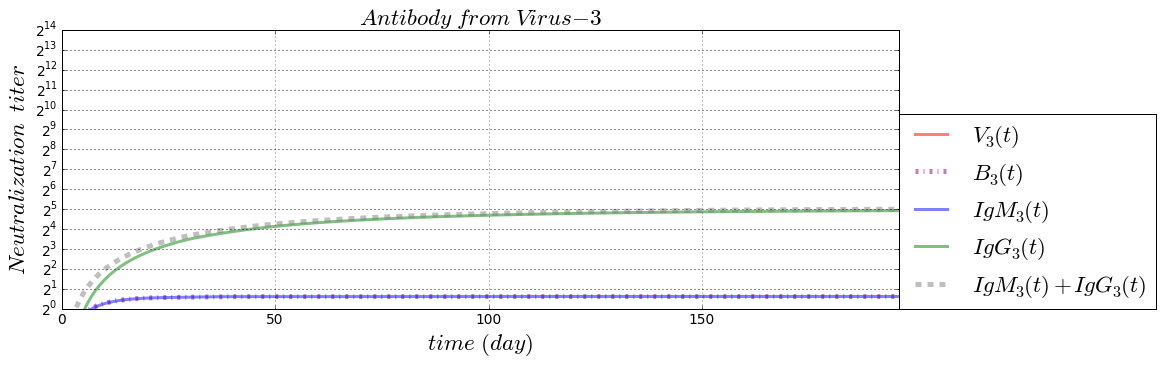

In [3]:
# step by step
numberingFig = numberingFig + 1
for i in range(totalPoint_X):
    figure_name = '-response-%i'%(i)
    figure_suffix = '.png'
    save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)
    plt.figure(numberingFig, figsize = AlvaFigSize)
    plt.plot(gT, gV[i], color = 'red', label = r'$ V_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gB[i], color = 'purple', label = r'$ B_{%i}(t) $'%(i), linewidth = 5.0, alpha = 0.5
             , linestyle = '-.')
    plt.plot(gT, gM[i], color = 'blue', label = r'$ IgM_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gG[i], color = 'green', label = r'$ IgG_{%i}(t) $'%(i), linewidth = 3.0, alpha = 0.5)
    plt.plot(gT, gM[i] + gG[i], color = 'gray', linewidth = 5.0, alpha = 0.5, linestyle = 'dashed'
             , label = r'$ IgM_{%i}(t) + IgG_{%i}(t) $'%(i, i))
    plt.grid(True, which = 'both')
    plt.title(r'$ Antibody \ from \ Virus-{%i} $'%(i), fontsize = AlvaFontSize)
    plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
    plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
    plt.xlim([minT, maxT])
    plt.xticks(fontsize = AlvaFontSize*0.6)
    plt.yticks(fontsize = AlvaFontSize*0.6) 
    plt.ylim([2**0, 2**14])
    plt.yscale('log', basey = 2)
    plt.legend(loc = (1,0), fontsize = AlvaFontSize)
    plt.savefig(save_figure, dpi = 100)
    plt.show()

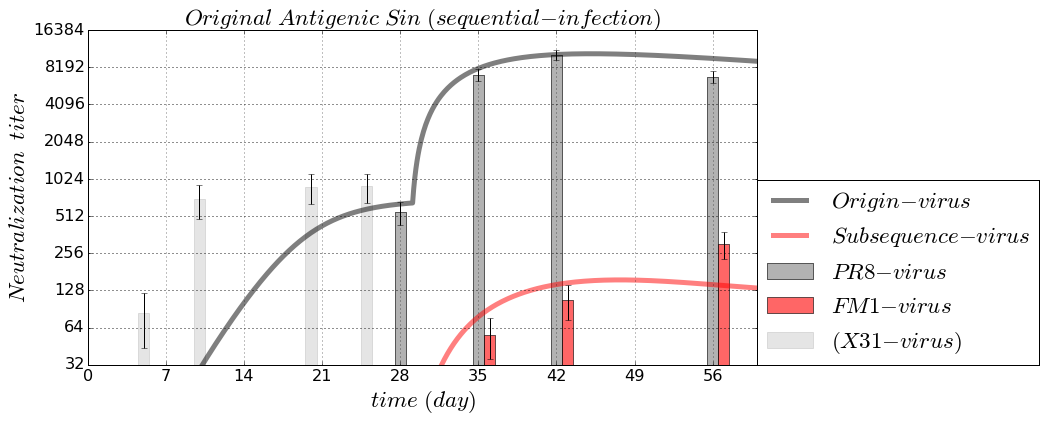

In [4]:
# Experimental lab data from (Quantifying the Early Immune Response and Adaptive Immune) paper
gT_lab_fresh = np.array([0, 5, 10, 20, 25])
gIgG_lab_fresh = np.array([0, 0.5, 4, 8.5, 8.75])*10**2 
error_IgG_fresh = gIgG_lab_fresh**(4.0/5)
gIgM_lab_fresh = np.array([0, 1.0/3, 3, 1.0/3, 1.0/6])*10**2
error_IgM_fresh = gIgM_lab_fresh**(4.0/5)
gX31_lab_fresh = gIgG_lab_fresh + gIgM_lab_fresh
error_lab_fresh = error_IgG_fresh + error_IgM_fresh
bar_width = 1

# Experimental lab data from OAS paper
gT_lab = np.array([28, 28 + 7, 28 + 14, 28 + 28]) 
gPR8_lab = np.array([2**(9 + 1.0/10), 2**(13 - 1.0/5), 2**(13 + 1.0/3), 2**(13 - 1.0/4)])
error_PR8 = gPR8_lab**(3.0/4)

gFM1_lab = np.array([0, 2**(6 - 1.0/5), 2**(7 - 1.0/4), 2**(8 + 1.0/4)])
error_FM1 = gFM1_lab**(3.0/4)
bar_width = 1.0

# Sequential infection graph
figure_name = '-Original-Antigenic-Sin-infection'
figure_suffix = '.png'
save_figure = os.path.join(dir_path, file_name + figure_name + file_suffix)
numberingFig = numberingFig + 1
plt.figure(numberingFig, figsize = (12, 6))
plt.subplot(111)
plt.plot(gT, (gM[origin_virus] + gG[origin_virus]), linewidth = 5.0, alpha = 0.5, color = 'black'
         , label = r'$ Origin-virus $')
plt.plot(gT, (gM[origin_virus + 1] + gG[origin_virus + 1]), linewidth = 5.0, alpha = 0.5, color = 'red'
         , label = r'$ Subsequence-virus $')
plt.bar(gT_lab - bar_width/2, gPR8_lab, bar_width, alpha = 0.6, color = 'gray', yerr = error_PR8
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ PR8-virus $')
plt.bar(gT_lab + bar_width/2, gFM1_lab, bar_width, alpha = 0.6, color = 'red', yerr = error_FM1
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ FM1-virus $')
plt.bar(gT_lab_fresh - bar_width/2, gX31_lab_fresh, bar_width, alpha = 0.1, color = 'black', yerr = error_lab_fresh
        , error_kw = dict(elinewidth = 1, ecolor = 'black'), label = r'$ (X31-virus) $')
plt.grid(True, which = 'both')
plt.title(r'$ Original \ Antigenic \ Sin \ (sequential-infection)$', fontsize = AlvaFontSize)
plt.xlabel(r'$time \ (%s)$'%(timeUnit), fontsize = AlvaFontSize)
plt.ylabel(r'$ Neutralization \ \ titer $', fontsize = AlvaFontSize)
plt.xticks(fontsize = AlvaFontSize*0.7)
plt.yticks(fontsize = AlvaFontSize*0.7) 
plt.xlim([minT, 2*30*day])
plt.ylim([2**5, 2**14])
plt.yscale('log', basey = 2)
# gca()---GetCurrentAxis and Format the ticklabel to be 2**x
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(2**(np.log(x)/np.log(2)))))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.legend(loc = (1, 0), fontsize = AlvaFontSize)
plt.savefig(save_figure, dpi = 100, bbox_inches='tight')
plt.show()